<h2>Import bibliotek</h2>

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

<h2>Zadanie 2.</h2>

<h3>Zdefiniowanie danych funkcji:</h3>
<ul>
    <li>$f_1(x) = \frac{1}{(1+25x^2)}$ na przedziale $[-1,1]$</li>
    <li>$f_2(x) = exp(cosx)$ na przedziale $[0,2\pi]$</li>
</ul>

In [8]:
# f1
def f1(x):
    return 1 / (1 + 25 * x**2)

# f2
def f2(x):
    return np.exp(np.cos(x))

<h3>Funkcje generujące węzły</h3>

In [68]:
# generate array of evenly distanced nodes
def uniform_nodes(n, range_start, range_end, function):
    js = np.arange(0, n)
    h = (range_end - range_start) / (n-1)
    xs = range_start + js * h
    ys = function(xs)
    return np.array([xs,ys]).T

# generate array of chebyshev nodes
def chebyshev_nodes(n, range_start, range_end, function):
    js = np.arange(1, n+1)
    thetas = (2*js - 1) / (2*n) * np.pi
    xs = (range_start + range_end) / 2 + (range_end - range_start) / 2 * (-np.cos(thetas))
    ys = function(xs)
    return np.array([xs, ys]).T

<h3>a) Interpolacja $f_1(x)$ dla $n = 12$</h3>

In [70]:
# define n
n = 12

Funkcje do interpolacji Lagrange'a

In [69]:
# calculate lagrange numerator
def lagrange_numerator(points, index, x):
    xs = points[:,0]
    factors = x - xs[xs != xs[index]]
    return np.prod(factors)

# calculate lagrange denominator
def lagrange_denominator(points, index):
    xs = points[:,0]
    factors = xs[index] - xs[xs != xs[index]]
    return np.prod(factors)

# calculate lagrange polynomial values (pass denominators to avoid unnecessert recomputation)
def lagrange_value(points, x, denominators):
    result = 0
    for index, point in enumerate(points):
        result += point[1] * lagrange_numerator(points, index, x) / denominators[index]
    return result

Wyznaczenie wielomianów interpolujących

In [81]:
# generate nodes
unif_nodes = uniform_nodes(n, -1, 1, f1)
cheb_nodes = chebyshev_nodes(n, -1, 1, f1)

# sample points (amount of sampled points = 10 * amount of nodes)
n_sample = 10*n
uniform_sample = uniform_nodes(n_sample, -1, 1, f1)
chebyshev_sample = chebyshev_nodes(n_sample, -1, 1, f1)

# sample points xs
xs_uniform = uniform_sample[:,0]
xs_chebyshev = chebyshev_sample[:,0]

# sample actual function
ys_f1 = uniform_sample[:,1]

# sample Lagrange for uniform nodes
lagrange_uniform_denominators = [lagrange_denominator(unif_nodes, index) for index in range(len(unif_nodes))]
ys_lagrange_uniform = [lagrange_value(unif_nodes, x, lagrange_uniform_denominators) for x in xs_uniform]

# sample Lagrange for chebyshev nodes
lagrange_chebyshev_denominators = [lagrange_denominator(cheb_nodes, index) for index in range(len(cheb_nodes))]
ys_lagrange_chebyshev = [lagrange_value(cheb_nodes, x, lagrange_chebyshev_denominators) for x in xs_chebyshev]

# sample cubic spline for uniform nodes
cubic_spline = sp.interpolate.CubicSpline(unif_nodes[:,0], unif_nodes[:,1])
ys_spline_uniform = cubic_spline(xs_uniform)

Narysowanie wykresu z wielomianami interpolacyjnymi

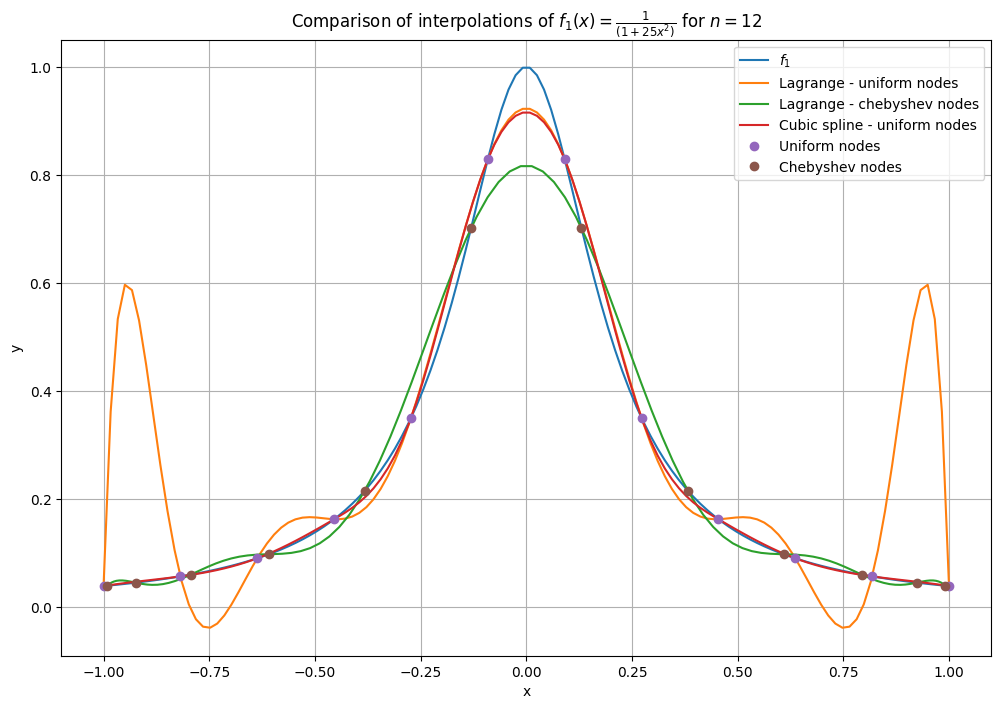

In [96]:
# set figsize
plt.figure(figsize = (12,8))
# add plot of interpolating polynomials and nodes
plt.plot(xs_uniform, ys_f1, label="$f_1$")
plt.plot(xs_uniform, ys_lagrange_uniform, label="Lagrange - uniform nodes")
plt.plot(xs_chebyshev, ys_lagrange_chebyshev, label="Lagrange - chebyshev nodes")
plt.plot(xs_uniform, ys_spline_uniform, label="Cubic spline - uniform nodes")
plt.plot(unif_nodes[:,0], unif_nodes[:,1], marker='o', linestyle='', label="Uniform nodes")
plt.plot(cheb_nodes[:,0], cheb_nodes[:,1], marker='o', linestyle='', label="Chebyshev nodes")
# add title and axes labels
plt.title(r"Comparison of interpolations of $f_1(x) = \frac{1}{(1+25x^2)}$ for $n = 12$")
plt.xlabel("x")
plt.ylabel("y")
# show with legend and grid
plt.legend()
plt.grid()
plt.show()

<h3>b) Porównanie metod interpolacji dla obu funkcji dla $n = 4, 5, ..., 50$</h3>